### Lalonde Dataset

A data frame with 614 observations (185 treated, 429 control). There are 10 variables measured for each individual:

- treat is the treatment assignment (1=treated, 0=control).
- age is age in years.
- educ is education in number of years of schooling.
- black is an indicator for African-American (1=African-American, 0=not).
- hispan is an indicator for being of Hispanic origin (1=Hispanic, 0=not).
- married is an indicator for married (1=married, 0=not married).
- nodegree is an indicator for whether the individual has a high school degree (1=no degree, 0=degree).
- re74 is income in 1974, in U.S. dollars.
- re75 is income in 1975, in U.S. dollars.
- re78 is income in 1978, in U.S. dollars.

In [127]:
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
df = pd.read_csv('/Users/pranjal/Desktop/ci/data/lalonde.csv')
covariates = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']
outcome = 're78'
treatment = 'treat'
print("First few rows of the data:")
display(df.head())

First few rows of the data:


,ID,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### Propensity Score Matching

Standard Deviation of Logit Propensity Score: 1.6911168845823017
Caliper Width: 0.33822337691646037


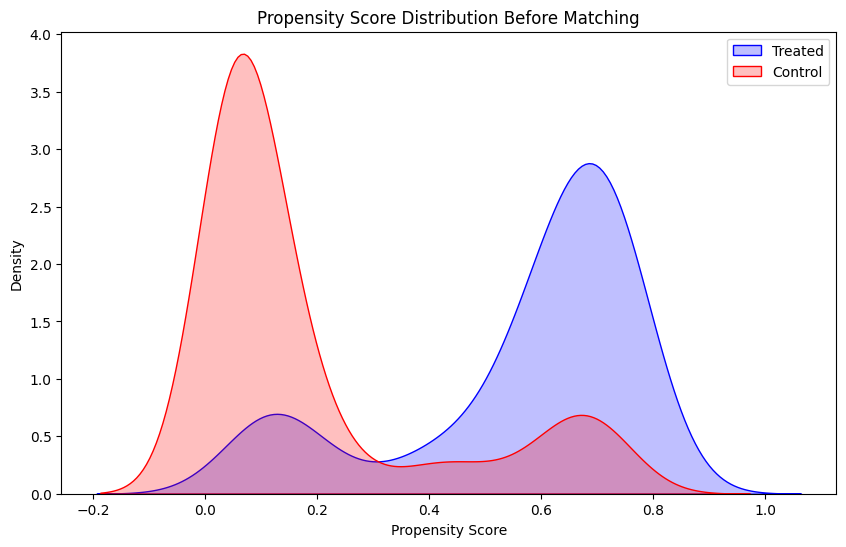

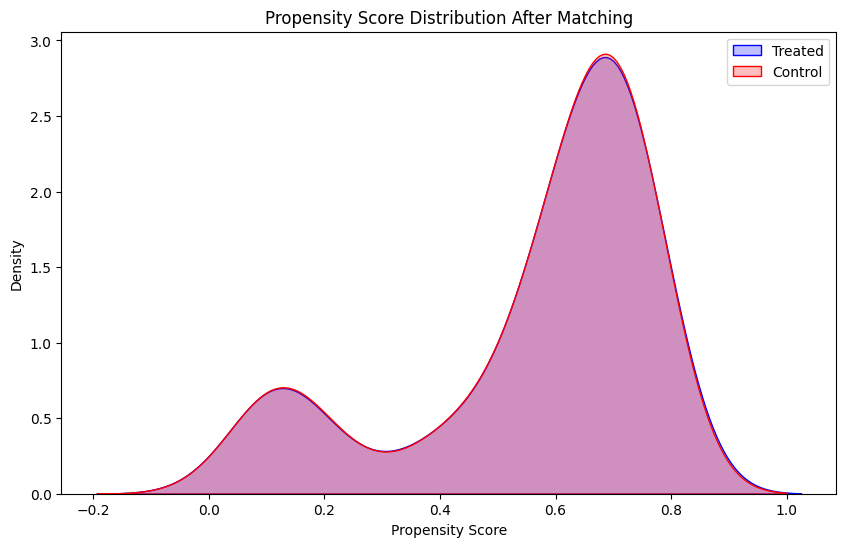


Method: Propensity Score Matching
Covariate Balance Before Matching:


,Covariate,Standardized Difference
0,age,-0.241904
1,educ,0.044755
2,black,1.667719
3,hispan,-0.276940
4,married,-0.719492
5,nodegree,0.235048
6,re74,-0.595752
7,re75,-0.287002


Covariate Balance After Matching:


,Covariate,Standardized Difference
0,age,0.334980
1,educ,-0.138885
2,black,0.029348
3,hispan,0.023367
4,married,0.100851
5,nodegree,0.093429
6,re74,0.005498
7,re75,-0.120916


Average Treatment Effect on the Treated (ATET): 1660.66095
Standard Error of ATET: 707.4163915020779


In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm

# Load the dataset
df = pd.read_csv('/Users/pranjal/Desktop/ci/data/lalonde.csv')

# Define covariates and outcome
covariates = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']
outcome = 're78'
treatment = 'treat'

# Estimate propensity scores using logistic regression
propensity_model = LogisticRegression(max_iter=10000)
propensity_model.fit(df[covariates], df[treatment])
df['propensity_score'] = propensity_model.predict_proba(df[covariates])[:, 1]

# Compute the logit of the propensity score
df['logit_propensity_score'] = np.log(df['propensity_score'] / (1 - df['propensity_score']))

# Calculate caliper width (0.2 * SD of the logit of the propensity score)
logit_ps_sd = df['logit_propensity_score'].std()
caliper = 0.2 * logit_ps_sd
print(f"Standard Deviation of Logit Propensity Score: {logit_ps_sd}")
print(f"Caliper Width: {caliper}")

# Separate treated and control groups
treated = df[df[treatment] == 1].copy()
control = df[df[treatment] == 0].copy()

# Plot KDE of propensity scores before matching
plt.figure(figsize=(10, 6))
sns.kdeplot(treated['propensity_score'], label='Treated', shade=True, color='blue')
sns.kdeplot(control['propensity_score'], label='Control', shade=True, color='red')
plt.title('Propensity Score Distribution Before Matching')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# Prepare data for matching
treated_scores = treated['logit_propensity_score'].values.reshape(-1, 1)
control_scores = control['logit_propensity_score'].values.reshape(-1, 1)

# Initialize NearestNeighbors with caliper as radius
nn = NearestNeighbors(radius=caliper, algorithm='ball_tree')
nn.fit(control_scores)

# Find control units within caliper for each treated unit
distances, indices = nn.radius_neighbors(treated_scores)

# Perform matching
matched_treated_indices = []
matched_control_indices = []

for i, neighbors in enumerate(indices):
    if len(neighbors) > 0:
        # Control units are within caliper
        treated_score = treated_scores[i]
        control_neighbor_scores = control_scores[neighbors]
        distance = np.abs(control_neighbor_scores - treated_score)
        min_distance_index = np.argmin(distance)
        matched_control_index = neighbors[min_distance_index]
        matched_treated_indices.append(treated.index[i])
        matched_control_indices.append(control.index[matched_control_index])
    else:
        # No control units within caliper; exclude treated unit
        continue

# Create matched DataFrame
matched_treated = df.loc[matched_treated_indices].copy()
matched_control = df.loc[matched_control_indices].copy()
matched_data = pd.concat([matched_treated, matched_control])

# Reset indices
matched_treated = matched_treated.reset_index(drop=True)
matched_control = matched_control.reset_index(drop=True)
matched_data = matched_data.reset_index(drop=True)

# Plot KDE of propensity scores after matching
plt.figure(figsize=(10, 6))
sns.kdeplot(matched_treated['propensity_score'], label='Treated', shade=True, color='blue')
sns.kdeplot(matched_control['propensity_score'], label='Control', shade=True, color='red')
plt.title('Propensity Score Distribution After Matching')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# Function to compute standardized differences
def covariate_balance(data, covariates, treated_col='treat'):
    results = []
    for covariate in covariates:
        mean_treated = data[data[treated_col] == 1][covariate].mean()
        mean_control = data[data[treated_col] == 0][covariate].mean()
        var_treated = data[data[treated_col] == 1][covariate].var()
        var_control = data[data[treated_col] == 0][covariate].var()
        sd_pooled = np.sqrt((var_treated + var_control) / 2)
        if sd_pooled == 0:
            standardized_diff = 0
        else:
            standardized_diff = (mean_treated - mean_control) / sd_pooled
        results.append({
            "Covariate": covariate,
            "Standardized Difference": standardized_diff
        })
    return pd.DataFrame(results)

# Covariate balance before matching
balance_before = covariate_balance(df, covariates)

# Covariate balance after matching
balance_after = covariate_balance(matched_data, covariates)

# Compute ATET and standard error using PSM
differences = matched_treated[outcome] - matched_control[outcome]
ATET_PSM = differences.mean()
stderr_PSM = differences.std(ddof=1) / np.sqrt(len(differences))

print("\nMethod: Propensity Score Matching")
print("Covariate Balance Before Matching:")
display(balance_before)
print("Covariate Balance After Matching:")
display(balance_after)
print(f"Average Treatment Effect on the Treated (ATET): {ATET_PSM}")
print(f"Standard Error of ATET: {stderr_PSM}")

### Regression and Matched Regression

In [117]:
# Bivariate OLS on full sample
X_bi_full = sm.add_constant(df[treatment])
Y_full = df[outcome]
model_bi_full = sm.OLS(Y_full, X_bi_full).fit()
ATE_bi_full = model_bi_full.params[treatment]
stderr_bi_full = model_bi_full.bse[treatment]

# Multivariate OLS on full sample
X_multi_full = sm.add_constant(df[[treatment] + covariates])
model_multi_full = sm.OLS(Y_full, X_multi_full).fit()
ATE_multi_full = model_multi_full.params[treatment]
stderr_multi_full = model_multi_full.bse[treatment]

# Bivariate OLS on matched sample
X_bi_matched = sm.add_constant(matched_data[treatment])
Y_matched = matched_data[outcome]
model_bi_matched = sm.OLS(Y_matched, X_bi_matched).fit()
ATET_bi_matched = model_bi_matched.params[treatment]
stderr_bi_matched = model_bi_matched.bse[treatment]

# Multivariate OLS on matched sample
X_multi_matched = sm.add_constant(matched_data[[treatment] + covariates])
model_multi_matched = sm.OLS(Y_matched, X_multi_matched).fit()
ATET_multi_matched = model_multi_matched.params[treatment]
stderr_multi_matched = model_multi_matched.bse[treatment]


# Create a summary table
results = pd.DataFrame({
    'Model': [
        'Bivariate OLS (Full Sample)',
        'Multivariate OLS (Full Sample)',
        'Bivariate OLS (Matched Sample)',
        'Multivariate OLS (Matched Sample)',
        'Propensity Score Matching'
    ],
    'Effect Type': [
        'ATE',
        'ATE',
        'ATET',
        'ATET',
        'ATET'
    ],
    'Estimate': [
        ATE_bi_full,
        ATE_multi_full,
        ATET_bi_matched,
        ATET_multi_matched,
        ATET_PSM
    ],
    'Standard Error': [
        stderr_bi_full,
        stderr_multi_full,
        stderr_bi_matched,
        stderr_multi_matched,
        stderr_PSM
    ]
})

print("\nSummary of Results:")
display(results)



Summary of Results:


,Model,Effect Type,Estimate,Standard Error
0,Bivariate OLS (Full Sample),ATE,-635.026212,657.137424
1,Multivariate OLS (Full Sample),ATE,1548.243802,781.279297
2,Bivariate OLS (Matched Sample),ATET,1660.660950,710.201546
3,Multivariate OLS (Matched Sample),ATET,1817.104084,716.018380
4,Propensity Score Matching,ATET,1660.660950,707.416392


### Subclassification Estimator with Propensity Scores


Data-Driven Procedure: Number of blocks after splitting: 10

Results for Stratification on the Propensity Score:


,Method,Number of Blocks,Valid Blocks,ATE,Standard Error
0,Fixed Blocks (2),2,2,1371.482550,946.195577
1,Fixed Blocks (3),3,3,1679.089721,1333.217404
2,Fixed Blocks (4),4,4,1111.960485,1229.724356
3,Fixed Blocks (5),5,5,-183.287583,1640.858527
4,Fixed Blocks (6),6,6,325.129257,1519.075434
5,Fixed Blocks (7),7,7,310.619017,1410.202000
6,Fixed Blocks (8),8,8,337.398111,1283.898794
7,Fixed Blocks (9),9,8,300.210456,1154.224505
8,Fixed Blocks (10),10,9,832.499077,1123.236432
9,Fixed Blocks (11),11,10,911.052045,1195.144831


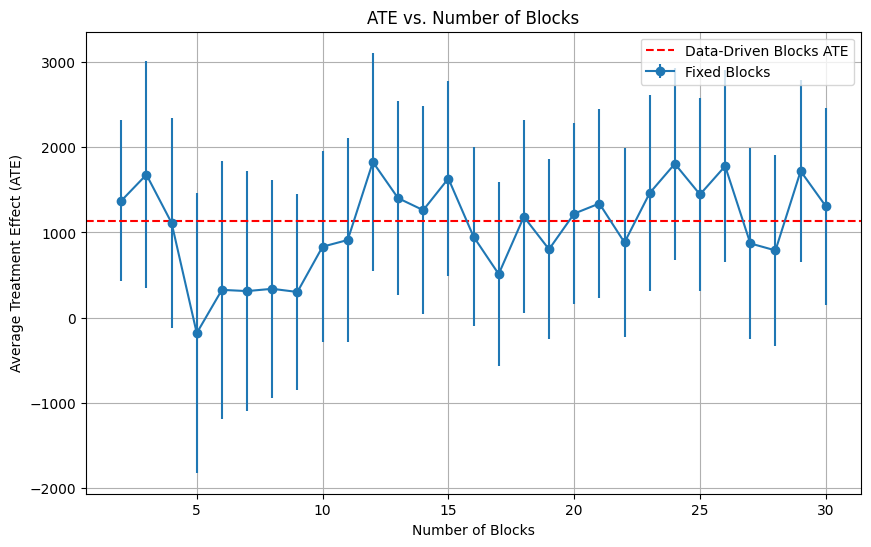

In [118]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Load the dataset
df = pd.read_csv('/Users/pranjal/Desktop/ci/data/lalonde.csv')

# Define covariates, treatment, and outcome
covariates = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']
treatment = 'treat'
outcome = 're78'

# Estimate propensity scores using logistic regression
from sklearn.linear_model import LogisticRegression
propensity_model = LogisticRegression(max_iter=10000)
propensity_model.fit(df[covariates], df[treatment])
df['propensity_score'] = propensity_model.predict_proba(df[covariates])[:, 1]

# Compute log-odds ratios (logit of propensity scores)
df['logit_propensity_score'] = np.log(df['propensity_score'] / (1 - df['propensity_score']))

# Initialize list to store results
results = []

# Define the range of blocks to check
min_blocks = 2
max_blocks = 30

# Iterate over the range of fixed blocks
for num_blocks in range(min_blocks, max_blocks + 1):
    try:
        # Stratify the data into num_blocks blocks using propensity score
        df['block'] = pd.qcut(df['propensity_score'], q=num_blocks, labels=False, duplicates='drop')
        
        # Initialize lists to store block-specific treatment effects and variances
        block_treatment_effects = []
        block_variances = []
        block_sizes = []
        valid_blocks = 0  # Counter for blocks with both treated and control units
        
        # Loop over each block
        for b in df['block'].unique():
            block_data = df[df['block'] == b]
            N_block = len(block_data)
            N_treated = block_data[treatment].sum()
            N_control = N_block - N_treated

            # Proceed only if both treated and control units are present
            if N_treated < 1 or N_control < 1:
                continue  # Skip blocks without both treated and control units

            valid_blocks += 1

            # Always include covariates in the regression model
            formula = f"{outcome} ~ {treatment} + " + " + ".join(covariates)

            # Fit regression model within block
            model = smf.ols(formula, data=block_data).fit()

            # Extract treatment effect and its variance
            TE_b = model.params[treatment]
            Var_b = model.bse[treatment] ** 2

            # Store results
            block_treatment_effects.append(TE_b)
            block_variances.append(Var_b)
            block_sizes.append(N_block)

        # Check if we have any valid blocks
        if valid_blocks == 0:
            print(f"No valid blocks for {num_blocks} blocks.")
            continue

        # Compute weights proportional to block sizes (for ATE)
        total_n = sum(block_sizes)
        weights = [n_b / total_n for n_b in block_sizes]

        # Calculate overall ATE
        ATE_Strat = sum(w * te for w, te in zip(weights, block_treatment_effects))
        variance_Strat = sum((w ** 2) * var_b for w, var_b in zip(weights, block_variances))
        stderr_Strat = np.sqrt(variance_Strat)

        # Store the results
        results.append({
            'Method': f'Fixed Blocks ({num_blocks})',
            'Number of Blocks': num_blocks,
            'Valid Blocks': valid_blocks,
            'ATE': ATE_Strat,
            'Standard Error': stderr_Strat
        })

    except Exception as e:
        print(f"An error occurred for {num_blocks} blocks: {e}")
        continue

# Now include the data-driven procedure

# Function to perform data-driven block splitting
def data_driven_blocks(data, max_t_stat=1.96, min_treated=3, min_control=3):
    data = data.copy()
    data['block'] = 1  # Start with one block
    blocks_to_check = [1]
    block_counter = 1  # Keep track of the current block number
    while blocks_to_check:
        current_block = blocks_to_check.pop(0)
        block_data = data[data['block'] == current_block]

        # Get treated and control units
        treated = block_data[block_data[treatment] == 1]
        control = block_data[block_data[treatment] == 0]

        # Sample sizes
        N_treated = len(treated)
        N_control = len(control)

        # Check if sample sizes are sufficient to split
        if N_treated < min_treated or N_control < min_control:
            continue  # Cannot split further due to small sample sizes

        # Compute means and variances of logit propensity scores
        mean_logit_treated = treated['logit_propensity_score'].mean()
        mean_logit_control = control['logit_propensity_score'].mean()
        var_logit_treated = treated['logit_propensity_score'].var(ddof=1)
        var_logit_control = control['logit_propensity_score'].var(ddof=1)

        # Compute t-statistic for difference in means
        numerator = mean_logit_treated - mean_logit_control
        denominator = np.sqrt(var_logit_treated / N_treated + var_logit_control / N_control)
        if denominator == 0:
            t_stat = 0
        else:
            t_stat = abs(numerator / denominator)

        # Check if block is adequate
        if t_stat > max_t_stat:
            # Block is not adequate, need to split
            # Split at median of propensity scores
            median_ps = block_data['propensity_score'].median()
            # Assign new block numbers
            data.loc[(data['block'] == current_block) & (data['propensity_score'] <= median_ps), 'block'] = block_counter + 1
            data.loc[(data['block'] == current_block) & (data['propensity_score'] > median_ps), 'block'] = block_counter + 2
            # Add new blocks to the list to check
            blocks_to_check.extend([block_counter + 1, block_counter + 2])
            block_counter += 2
        else:
            # Block is adequate, no need to split further
            continue
    return data

# Apply the data-driven procedure
df_dd = data_driven_blocks(df)
num_blocks_dd = df_dd['block'].nunique()
print(f"\nData-Driven Procedure: Number of blocks after splitting: {num_blocks_dd}")

# Initialize lists to store block-specific treatment effects and variances
block_treatment_effects_dd = []
block_variances_dd = []
block_sizes_dd = []
valid_blocks_dd = 0  # Counter for blocks with both treated and control units

# Loop over each block
for b in df_dd['block'].unique():
    block_data = df_dd[df_dd['block'] == b]
    N_block = len(block_data)
    N_treated = block_data[treatment].sum()
    N_control = N_block - N_treated

    # Proceed only if both treated and control units are present
    if N_treated < 1 or N_control < 1:
        continue  # Skip blocks without both treated and control units

    valid_blocks_dd += 1

    # Always include covariates in the regression model
    formula = f"{outcome} ~ {treatment} + " + " + ".join(covariates)

    # Fit regression model within block
    model = smf.ols(formula, data=block_data).fit()

    # Extract treatment effect and its variance
    TE_b = model.params[treatment]
    Var_b = model.bse[treatment] ** 2

    # Store results
    block_treatment_effects_dd.append(TE_b)
    block_variances_dd.append(Var_b)
    block_sizes_dd.append(N_block)

# Check if we have any valid blocks
if valid_blocks_dd == 0:
    print("No valid blocks in data-driven procedure.")
else:
    # Compute weights proportional to block sizes (for ATE)
    total_n_dd = sum(block_sizes_dd)
    weights_dd = [n_b / total_n_dd for n_b in block_sizes_dd]

    # Calculate overall ATE
    ATE_Strat_dd = sum(w * te for w, te in zip(weights_dd, block_treatment_effects_dd))
    variance_Strat_dd = sum((w ** 2) * var_b for w, var_b in zip(weights_dd, block_variances_dd))
    stderr_Strat_dd = np.sqrt(variance_Strat_dd)

    # Store the results
    results.append({
        'Method': 'Data-Driven Blocks',
        'Number of Blocks': num_blocks_dd,
        'Valid Blocks': valid_blocks_dd,
        'ATE': ATE_Strat_dd,
        'Standard Error': stderr_Strat_dd
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("\nResults for Stratification on the Propensity Score:")
display(results_df)

import matplotlib.pyplot as plt

# Separate fixed blocks and data-driven blocks
fixed_blocks_df = results_df[results_df['Method'].str.contains('Fixed Blocks')].copy()
data_driven_df = results_df[results_df['Method'] == 'Data-Driven Blocks'].copy()

plt.figure(figsize=(10, 6))
plt.errorbar(fixed_blocks_df['Number of Blocks'], fixed_blocks_df['ATE'], yerr=fixed_blocks_df['Standard Error'], fmt='-o', label='Fixed Blocks')
plt.axhline(y=data_driven_df['ATE'].values[0], color='r', linestyle='--', label='Data-Driven Blocks ATE')
plt.xlabel('Number of Blocks')
plt.ylabel('Average Treatment Effect (ATE)')
plt.title('ATE vs. Number of Blocks')
plt.legend()
plt.grid(True)
plt.show()


### Inverse Probability Weighing


In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# Load the dataset
df = pd.read_csv('/Users/pranjal/Desktop/ci/data/lalonde.csv')

# Define covariates, treatment, and outcome
covariates = [
    'age', 'educ', 'black', 'hispan', 'married',
    'nodegree', 're74', 're75'
]
treatment = 'treat'
outcome = 're78'

# Estimate propensity scores using logistic regression
propensity_model = LogisticRegression(max_iter=10000)
propensity_model.fit(df[covariates], df[treatment])
df['propensity_score'] = propensity_model.predict_proba(df[covariates])[:, 1]

# Function to compute standardized differences
def compute_standardized_differences(data, covariates, weights=None, treatment_col='treat'):
    results = []
    for covariate in covariates:
        if weights is not None:
            # Weighted means and variances
            treated = data[data[treatment_col] == 1]
            control = data[data[treatment_col] == 0]
            mean_treated = np.average(
                treated[covariate], weights=treated[weights]
            )
            mean_control = np.average(
                control[covariate], weights=control[weights]
            )
            var_treated = np.average(
                (treated[covariate] - mean_treated) ** 2,
                weights=treated[weights]
            )
            var_control = np.average(
                (control[covariate] - mean_control) ** 2,
                weights=control[weights]
            )
        else:
            # Unweighted means and variances
            mean_treated = data[data[treatment_col] == 1][covariate].mean()
            mean_control = data[data[treatment_col] == 0][covariate].mean()
            var_treated = data[data[treatment_col] == 1][covariate].var()
            var_control = data[data[treatment_col] == 0][covariate].var()
        sd_pooled = np.sqrt((var_treated + var_control) / 2)
        if sd_pooled == 0:
            standardized_diff = 0
        else:
            standardized_diff = (mean_treated - mean_control) / sd_pooled
        results.append({
            "Covariate": covariate,
            "Standardized Difference": standardized_diff
        })
    return pd.DataFrame(results)

# Covariate balance before weighting
balance_before = compute_standardized_differences(df, covariates)
average_abs_std_diff_before = balance_before['Standardized Difference'].abs().mean()

# Initialize lists to store results
methods = []
estimands = []
estimate_list = []
stderr_list = []
avg_abs_std_diff_after_list = []
reduction_list = []

### ATE Estimation ###

## 1. IPTW for ATE ##
# Calculate IPTW weights for ATE estimation
df['iptw_ate'] = np.where(
    df[treatment] == 1,
    1 / df['propensity_score'],
    1 / (1 - df['propensity_score'])
)

# Fit weighted regression model using IPTW weights
model_iptw_ate = sm.WLS(df[outcome], sm.add_constant(df[treatment]), weights=df['iptw_ate']).fit()
ATE_IPTW = model_iptw_ate.params[treatment]
stderr_IPTW = model_iptw_ate.bse[treatment]

# Covariate balance after IPTW weighting
balance_after_iptw_ate = compute_standardized_differences(df, covariates, weights='iptw_ate')
average_abs_std_diff_iptw_ate = balance_after_iptw_ate['Standardized Difference'].abs().mean()
reduction_iptw_ate = average_abs_std_diff_before - average_abs_std_diff_iptw_ate

# Store results
methods.append('IPTW')
estimands.append('ATE')
estimate_list.append(ATE_IPTW)
stderr_list.append(stderr_IPTW)
avg_abs_std_diff_after_list.append(average_abs_std_diff_iptw_ate)
reduction_list.append(reduction_iptw_ate)

## 2. Stabilized IPTW for ATE ##
# Calculate stabilized IPTW weights for ATE estimation
p_treatment = df[treatment].mean()
df['stabilized_iptw_ate'] = np.where(
    df[treatment] == 1,
    p_treatment / df['propensity_score'],
    (1 - p_treatment) / (1 - df['propensity_score'])
)

# Fit weighted regression model using stabilized IPTW weights
model_stabilized_ate = sm.WLS(df[outcome], sm.add_constant(df[treatment]), weights=df['stabilized_iptw_ate']).fit()
ATE_Stabilized = model_stabilized_ate.params[treatment]
stderr_Stabilized = model_stabilized_ate.bse[treatment]

# Covariate balance after stabilized IPTW weighting
balance_after_stabilized_ate = compute_standardized_differences(df, covariates, weights='stabilized_iptw_ate')
average_abs_std_diff_stabilized_ate = balance_after_stabilized_ate['Standardized Difference'].abs().mean()
reduction_stabilized_ate = average_abs_std_diff_before - average_abs_std_diff_stabilized_ate

# Store results
methods.append('Stabilized IPTW')
estimands.append('ATE')
estimate_list.append(ATE_Stabilized)
stderr_list.append(stderr_Stabilized)
avg_abs_std_diff_after_list.append(average_abs_std_diff_stabilized_ate)
reduction_list.append(reduction_stabilized_ate)

## 3. IPTW with Trimming for ATE ##
# Determine the trimming threshold (e.g., 99th percentile)
threshold_ate = df['iptw_ate'].quantile(0.99)

# Trim weights
df['iptw_ate_trimmed'] = np.minimum(df['iptw_ate'], threshold_ate)

# Fit weighted regression model using trimmed IPTW weights
model_trimmed_ate = sm.WLS(df[outcome], sm.add_constant(df[treatment]), weights=df['iptw_ate_trimmed']).fit()
ATE_Trimmed = model_trimmed_ate.params[treatment]
stderr_Trimmed = model_trimmed_ate.bse[treatment]

# Covariate balance after IPTW with weight trimming
balance_after_trimmed_ate = compute_standardized_differences(df, covariates, weights='iptw_ate_trimmed')
average_abs_std_diff_trimmed_ate = balance_after_trimmed_ate['Standardized Difference'].abs().mean()
reduction_trimmed_ate = average_abs_std_diff_before - average_abs_std_diff_trimmed_ate

# Store results
methods.append('IPTW with Trimming')
estimands.append('ATE')
estimate_list.append(ATE_Trimmed)
stderr_list.append(stderr_Trimmed)
avg_abs_std_diff_after_list.append(average_abs_std_diff_trimmed_ate)
reduction_list.append(reduction_trimmed_ate)

## 4. Overlap Weights for ATE ##
# Calculate overlap weights
df['overlap_weight_ate'] = np.minimum(df['propensity_score'], 1 - df['propensity_score'])

# Fit weighted regression model using overlap weights
model_overlap_ate = sm.WLS(df[outcome], sm.add_constant(df[treatment]), weights=df['overlap_weight_ate']).fit()
ATE_Overlap = model_overlap_ate.params[treatment]
stderr_Overlap = model_overlap_ate.bse[treatment]

# Covariate balance after overlap weighting
balance_after_overlap_ate = compute_standardized_differences(df, covariates, weights='overlap_weight_ate')
average_abs_std_diff_overlap_ate = balance_after_overlap_ate['Standardized Difference'].abs().mean()
reduction_overlap_ate = average_abs_std_diff_before - average_abs_std_diff_overlap_ate

# Store results
methods.append('Overlap Weights')
estimands.append('ATE')
estimate_list.append(ATE_Overlap)
stderr_list.append(stderr_Overlap)
avg_abs_std_diff_after_list.append(average_abs_std_diff_overlap_ate)
reduction_list.append(reduction_overlap_ate)

### ATET Estimation ###

## 1. IPTW for ATET ##
# Calculate IPTW ATT weights
df['iptw_att'] = np.where(
    df[treatment] == 1,
    1,  # weight = 1 for treated units
    df['propensity_score'] / (1 - df['propensity_score'])  # for control units
)

# Fit weighted regression model using IPTW ATT weights
model_iptw_att = sm.WLS(df[outcome], sm.add_constant(df[treatment]), weights=df['iptw_att']).fit()
ATET_IPTW = model_iptw_att.params[treatment]
stderr_IPTW_att = model_iptw_att.bse[treatment]

# Covariate balance after IPTW ATT weighting
balance_after_iptw_att = compute_standardized_differences(df, covariates, weights='iptw_att')
average_abs_std_diff_iptw_att = balance_after_iptw_att['Standardized Difference'].abs().mean()
reduction_iptw_att = average_abs_std_diff_before - average_abs_std_diff_iptw_att

# Store results
methods.append('IPTW')
estimands.append('ATET')
estimate_list.append(ATET_IPTW)
stderr_list.append(stderr_IPTW_att)
avg_abs_std_diff_after_list.append(average_abs_std_diff_iptw_att)
reduction_list.append(reduction_iptw_att)

## 2. Stabilized IPTW for ATET ##
# Calculate stabilized IPTW ATT weights
df['stabilized_iptw_att'] = np.where(
    df[treatment] == 1,
    1,  # weight = 1 for treated units
    (p_treatment / (1 - p_treatment)) * (df['propensity_score'] / (1 - df['propensity_score']))
)

# Fit weighted regression model using stabilized IPTW ATT weights
model_stabilized_att = sm.WLS(df[outcome], sm.add_constant(df[treatment]), weights=df['stabilized_iptw_att']).fit()
ATET_Stabilized = model_stabilized_att.params[treatment]
stderr_Stabilized_att = model_stabilized_att.bse[treatment]

# Covariate balance after stabilized IPTW ATT weighting
balance_after_stabilized_att = compute_standardized_differences(df, covariates, weights='stabilized_iptw_att')
average_abs_std_diff_stabilized_att = balance_after_stabilized_att['Standardized Difference'].abs().mean()
reduction_stabilized_att = average_abs_std_diff_before - average_abs_std_diff_stabilized_att

# Store results
methods.append('Stabilized IPTW')
estimands.append('ATET')
estimate_list.append(ATET_Stabilized)
stderr_list.append(stderr_Stabilized_att)
avg_abs_std_diff_after_list.append(average_abs_std_diff_stabilized_att)
reduction_list.append(reduction_stabilized_att)

## 3. IPTW with Trimming for ATET ##
# Determine the trimming threshold for control units (e.g., 99th percentile)
threshold_att = df[df[treatment] == 0]['iptw_att'].quantile(0.99)

# Trim weights
df['iptw_att_trimmed'] = df['iptw_att']
df.loc[df[treatment] == 0, 'iptw_att_trimmed'] = np.minimum(
    df.loc[df[treatment] == 0, 'iptw_att'], threshold_att
)

# Fit weighted regression model using trimmed IPTW ATT weights
model_trimmed_att = sm.WLS(df[outcome], sm.add_constant(df[treatment]), weights=df['iptw_att_trimmed']).fit()
ATET_Trimmed = model_trimmed_att.params[treatment]
stderr_Trimmed_att = model_trimmed_att.bse[treatment]

# Covariate balance after IPTW ATT with weight trimming
balance_after_trimmed_att = compute_standardized_differences(df, covariates, weights='iptw_att_trimmed')
average_abs_std_diff_trimmed_att = balance_after_trimmed_att['Standardized Difference'].abs().mean()
reduction_trimmed_att = average_abs_std_diff_before - average_abs_std_diff_trimmed_att

# Store results
methods.append('IPTW with Trimming')
estimands.append('ATET')
estimate_list.append(ATET_Trimmed)
stderr_list.append(stderr_Trimmed_att)
avg_abs_std_diff_after_list.append(average_abs_std_diff_trimmed_att)
reduction_list.append(reduction_trimmed_att)

## 4. Overlap Weights for ATET ##
# Calculate overlap weights
df['overlap_weight_atet'] = np.where(
    df[treatment] == 1,
    1 - df['propensity_score'],
    df['propensity_score']
)

# Normalize weights to estimate ATET
df['overlap_weight_atet_normalized'] = df['overlap_weight_atet']
df.loc[df[treatment] == 1, 'overlap_weight_atet_normalized'] = (
    df.loc[df[treatment] == 1, 'overlap_weight_atet'] /
    df.loc[df[treatment] == 1, 'overlap_weight_atet'].sum()
)
df.loc[df[treatment] == 0, 'overlap_weight_atet_normalized'] = (
    df.loc[df[treatment] == 0, 'overlap_weight_atet'] /
    df.loc[df[treatment] == 0, 'overlap_weight_atet'].sum()
)

# Fit weighted regression model using overlap weights
model_overlap_atet = sm.WLS(df[outcome], sm.add_constant(df[treatment]), weights=df['overlap_weight_atet_normalized']).fit()
ATET_Overlap = model_overlap_atet.params[treatment]
stderr_Overlap_atet = model_overlap_atet.bse[treatment]

# Covariate balance after overlap weighting
balance_after_overlap_atet = compute_standardized_differences(df, covariates, weights='overlap_weight_atet_normalized')
average_abs_std_diff_overlap_atet = balance_after_overlap_atet['Standardized Difference'].abs().mean()
reduction_overlap_atet = average_abs_std_diff_before - average_abs_std_diff_overlap_atet

# Store results
methods.append('Overlap Weights')
estimands.append('ATET')
estimate_list.append(ATET_Overlap)
stderr_list.append(stderr_Overlap_atet)
avg_abs_std_diff_after_list.append(average_abs_std_diff_overlap_atet)
reduction_list.append(reduction_overlap_atet)

# Create a summary table
results = pd.DataFrame({
    'Method': methods,
    'Estimand': estimands,
    'Estimate': estimate_list,
    'Standard Error': stderr_list,
    'Avg Abs Std Diff Before': [average_abs_std_diff_before]*8,
    'Avg Abs Std Diff After': avg_abs_std_diff_after_list,
    'Reduction in Avg Abs Std Diff': reduction_list
})

print("\nSummary of Weighted Estimation Results:")
display(results)



Summary of Weighted Estimation Results:


,Method,Estimand,Estimate,Standard Error,Avg Abs Std Diff Before,Avg Abs Std Diff After,Reduction in Avg Abs Std Diff
0,IPTW,ATE,237.688754,585.963877,0.508576,0.156934,0.351642
1,Stabilized IPTW,ATE,237.688754,650.692279,0.508576,0.156934,0.351642
2,IPTW with Trimming,ATE,461.853461,591.964794,0.508576,0.174801,0.333775
3,Overlap Weights,ATE,367.411673,562.329901,0.508576,0.283923,0.224653
4,IPTW,ATET,1199.140388,570.210214,0.508576,0.033246,0.475331
5,Stabilized IPTW,ATET,1199.140388,652.947767,0.508576,0.033246,0.475331
6,IPTW with Trimming,ATET,1187.206750,570.961013,0.508576,0.034124,0.474453
7,Overlap Weights,ATET,1209.423971,562.837156,0.508576,0.017924,0.490652


### Regression Adjustment using Propensity Score

In [123]:
# Prepare data for regression
X = df[[treatment, 'propensity_score']]
X = sm.add_constant(X)
Y = df[outcome]

# Fit linear regression model
model = sm.OLS(Y, X).fit()
ATE_Adj = model.params[treatment]
stderr_Adj = model.bse[treatment]

print("\nMethod: Covariate Adjustment Using the Propensity Score")
print(f"Average Treatment Effect (ATE): {ATE_Adj}")
print(f"Standard Error of ATE: {stderr_Adj}")


Method: Covariate Adjustment Using the Propensity Score
Average Treatment Effect (ATE): 1280.5565197891874
Standard Error of ATE: 833.3859020398122


#### Summary Table

In [125]:
# Create a summary table
results = pd.DataFrame({
    'Method': [
        'Propensity Score Matching',
        'Stratification on the Propensity Score',
        'Inverse Probability of Treatment Weighting (IPTW)',
        'Covariate Adjustment Using PS'
    ],
    'ATE': [
        ATE_PSM,
        ATE_Strat,
        ATE_IPTW,
        ATE_Adj
    ],
    'Standard Error': [
        stderr_PSM,
        stderr_Strat,
        stderr_IPTW,
        stderr_Adj
    ]
})

print("\nSummary of Results:")
display(results)


Summary of Results:


,Method,ATE,Standard Error
0,Propensity Score Matching,1660.660950,707.416392
1,Stratification on the Propensity Score,1308.015154,1156.647315
2,Inverse Probability of Treatment Weighting (IPTW),237.688754,585.963877
3,Covariate Adjustment Using PS,1280.556520,833.385902
